<a href="https://colab.research.google.com/github/AidanMo1/test/blob/main/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pandas openpyxl
!pip install pydeseq2

In [7]:
import pandas as pd
import gzip

accessions = []
characteristics = []

with gzip.open('/content/GSE130955_series_matrix.txt.gz', 'rt') as f:
    for line in f:
        if line.startswith('!Sample_geo_accession'):
            accessions = [x.strip('"') for x in line.strip().split('\t')[1:]]
        elif line.startswith('!Sample_characteristics_ch1'):
            characteristics.append([x.strip('"') for x in line.strip().split('\t')[1:]])
        elif line.startswith('!series_matrix_table_begin'):
            break

sample_data = []
for i in range(len(accessions)):
    sample_chars = [characteristics[j][i] for j in range(len(characteristics))]
    sex = None
    for char in sample_chars:
        if 'sex' in char.lower():
            sex_val = char.split(':')[-1].strip()
            sex = 'Female' if sex_val == '0' else 'Male'
            break
    sample_data.append({'Accession': accessions[i], 'Sex': sex})

df_metadata = pd.DataFrame(sample_data)
groups = df_metadata.groupby('Sex')['Accession'].apply(list).to_dict()

print(sample_data)

[{'Accession': 'GSM3757031', 'Sex': 'Male'}, {'Accession': 'GSM3757032', 'Sex': 'Male'}, {'Accession': 'GSM3757033', 'Sex': 'Male'}, {'Accession': 'GSM3757034', 'Sex': 'Female'}, {'Accession': 'GSM3757035', 'Sex': 'Female'}, {'Accession': 'GSM3757036', 'Sex': 'Male'}, {'Accession': 'GSM3757037', 'Sex': 'Male'}, {'Accession': 'GSM3757038', 'Sex': 'Male'}, {'Accession': 'GSM3757039', 'Sex': 'Female'}, {'Accession': 'GSM3757040', 'Sex': 'Female'}, {'Accession': 'GSM3757041', 'Sex': 'Female'}, {'Accession': 'GSM3757042', 'Sex': 'Male'}, {'Accession': 'GSM3757043', 'Sex': 'Female'}, {'Accession': 'GSM3757044', 'Sex': 'Female'}, {'Accession': 'GSM3757045', 'Sex': 'Female'}, {'Accession': 'GSM3757046', 'Sex': 'Male'}, {'Accession': 'GSM3757047', 'Sex': 'Female'}, {'Accession': 'GSM3757048', 'Sex': 'Female'}, {'Accession': 'GSM3757049', 'Sex': 'Female'}, {'Accession': 'GSM3757050', 'Sex': 'Male'}, {'Accession': 'GSM3757051', 'Sex': 'Male'}, {'Accession': 'GSM3757052', 'Sex': 'Male'}, {'Accessi

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

# 1. Load Data
# Assuming 'df_metadata' is the dataframe from the previous step
df_tpm = pd.read_csv('/content/GSE130955_norm_counts_TPM_GRCh38.p13_NCBI.tsv.gz', sep='\t', compression='gzip')
df_tpm.set_index('GeneID', inplace=True)

# 2. Define Groups
females = df_metadata[df_metadata['Sex'] == 'Female']['Accession'].tolist()
males = df_metadata[df_metadata['Sex'] == 'Male']['Accession'].tolist()

# Filter to ensure columns exist in the TPM file
females = [c for c in females if c in df_tpm.columns]
males = [c for c in males if c in df_tpm.columns]

# 3. Calculate Statistics
# Add 1 to TPM values before logging to avoid -inf results (log2(TPM+1))
df_tpm['Mean_Female'] = df_tpm[females].mean(axis=1)
df_tpm['Mean_Male'] = df_tpm[males].mean(axis=1)
# To handle multiple modes, we take the first one found (iloc[:, 0])
df_tpm['Mode_Female'] = df_tpm[females].mode(axis=1).iloc[:, 0]
df_tpm['Mode_Male'] = df_tpm[males].mode(axis=1).iloc[:, 0]
df_tpm['Median_Female'] = df_tpm[females].median(axis=1)
df_tpm['Median_Male'] = df_tpm[males].median(axis=1)
df_tpm['Log2FC'] = np.log2((df_tpm['Mean_Male'] + 1) / (df_tpm['Mean_Female'] + 1))

# 4. Perform T-Test (Welch's T-test)
def run_ttest(row):
    # equal_var=False handles different group sizes/variances
    stat, pval = ttest_ind(row[females], row[males], equal_var=False)
    return pval

df_tpm['p_value'] = df_tpm.apply(run_ttest, axis=1)

# 5. Filter for significance
# Typically: p < 0.05 and |Log2FC| > 1
significant_results = df_tpm[(df_tpm['p_value'] < 0.05) & (abs(df_tpm['Log2FC']) > 0.5)]

df = pd.DataFrame(significant_results)
filename= "p-value_norm_sig.csv"
df.to_csv(filename)

df = pd.DataFrame(df_tpm)
filename1= "p-value_norm.csv"
df.to_csv(filename1)

#print(df_tpm)
print(significant_results.head())

           GSM3757031  GSM3757032  GSM3757033  GSM3757034  GSM3757035  \
GeneID                                                                  
100189133      3.0510      10.570      2.1210      5.4780      2.1930   
1301          43.5500      15.230     25.6500      0.4117     14.8900   
284612         0.4126       1.470      0.8809      0.5291      0.6143   
100189056      0.0000       3.216      3.2260      7.7760      4.4480   
100847044      1.9540       1.016      4.0740     21.0500      8.4270   

           GSM3757036  GSM3757037  GSM3757038  GSM3757039  GSM3757040  ...  \
GeneID                                                                 ...   
100189133       1.065       3.389      7.1310       4.442       1.544  ...   
1301            3.695       3.992     92.7800       6.610       7.585  ...   
284612          3.311       1.375      0.8541       1.487       3.252  ...   
100189056       3.238       1.145      1.4460       1.501       3.132  ...   
100847044       5.11

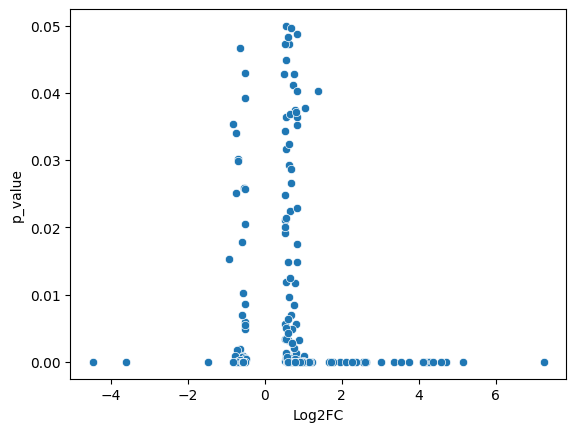

In [10]:
# Library & Dataset
import seaborn as sns
import pandas as pd # Import pandas to read CSV files
import matplotlib.pyplot as plt # Import matplotlib for plt.show()

# Load the CSV file created in the previous step
df = pd.read_csv('/content/p-value_norm_sig.csv')

# Plot
# Note: The original plotting code used 'sepal_length' and 'sepal_width'
# which are likely from an 'iris' dataset. You will need to replace these
# with appropriate column names from your loaded 'significant_results' DataFrame.
# For example, to plot Log2FC vs p_value, you might use:
sns.scatterplot(
  data=df,
  x='Log2FC',
  y='p_value'
)
plt.show()

In [12]:
import pandas as pd

# Load only the metadata section (usually the first ~100 lines)
# We use a large nrows to ensure we capture all characteristic lines
metadata = pd.read_csv('GSE130955_series_matrix.txt', sep='\t', nrows=100, header=None)

# 1. Extract the specific metadata rows
# We search for the characteristic labels in the first column
sex_row = metadata[metadata[0].str.contains('sex', case=False, na=False)]
age_row = metadata[metadata[0].str.contains('age', case=False, na=False)]
dur_row = metadata[metadata[0].str.contains('disease duration', case=False, na=False)]
grp_row = metadata[metadata[0].str.contains('disease group', case=False, na=False)]

# 2. Transpose and clean the data
def clean_metadata(row):
    # Remove the label (e.g., "sex: ") and transpose to a list
    values = row.iloc[0, 1:].str.split(': ').str[-1].tolist()
    return values

df = pd.DataFrame({
    'Sample_ID': metadata.iloc[30, 1:].tolist(), # Row containing GSM IDs
    'Group': clean_metadata(grp_row),
    'Sex': clean_metadata(sex_row),
    'Age': pd.to_numeric(clean_metadata(age_row), errors='coerce'),
    'Duration': pd.to_numeric(clean_metadata(dur_row), errors='coerce')
})

# 3. Filter for SSc patients and calculate the new column
# Healthy controls (HC) typically won't have a disease duration
ssc_df = df[df['Group'] == 'SSc'].copy()
ssc_df['Age_Minus_Duration'] = ssc_df['Age'] - ssc_df['Duration']

# 4. Display the final comparison table
comparison_table = ssc_df[['Sex', 'Age', 'Duration', 'Age_Minus_Duration']]
print(comparison_table.head())

FileNotFoundError: [Errno 2] No such file or directory: 'GSE130955_series_matrix.txt'

In [15]:
import pandas as pd

# Assume 'accessions' and 'characteristics' are available from previous cell execution (6n_sZdNEkyhA)

sample_data_detailed = []
for i in range(len(accessions)):
    sample_chars = [characteristics[j][i] for j in range(len(characteristics))]

    sample_id = accessions[i]
    group = None
    sex = None
    age = None
    duration = None

    for char_str in sample_chars:
        if 'diagnosis' in char_str.lower(): # Changed from 'disease group'
            diagnosis_val = char_str.split(':')[-1].strip()
            if 'ssc' in diagnosis_val.lower():
                group = 'SSc'
            elif 'healthy control' in diagnosis_val.lower():
                group = 'Healthy Control'
            else:
                group = diagnosis_val # Keep other diagnoses as is
        elif 'sex' in char_str.lower():
            sex_val = char_str.split(':')[-1].strip()
            sex = 'Female' if sex_val == '0' else 'Male'
        elif 'age' in char_str.lower():
            try:
                age = float(char_str.split(':')[-1].strip())
            except ValueError:
                age = None # or np.nan
        elif 'disease duration' in char_str.lower():
            try:
                duration = float(char_str.split(':')[-1].strip())
            except ValueError:
                duration = None # or np.nan

    sample_data_detailed.append({
        'Sample_ID': sample_id,
        'Group': group,
        'Sex': sex,
        'Age': age,
        'Duration': duration
    })

df = pd.DataFrame(sample_data_detailed)

# Filter for SSc patients and calculate the new column
ssc_df = df[df['Group'] == 'SSc'].copy()
ssc_df['Age_Minus_Duration'] = ssc_df['Age'] - ssc_df['Duration']

# Display the final comparison table
comparison_table = ssc_df[['Sex', 'Age', 'Duration', 'Age_Minus_Duration']]
print(comparison_table.head())

      Sex        Age  Duration  Age_Minus_Duration
0    Male  63.238877  0.865161           62.373717
1    Male  64.199863  1.826146           62.373717
2    Male  65.023956  2.650240           62.373717
4  Female  46.674880  1.796030           44.878850
5    Male  26.288843  1.127995           25.160849


In [11]:

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pandas as pd

# --- PREPARE METADATA ---
# Use the metadata we extracted earlier
metadata = df_metadata.set_index('Accession')
# Ensure 'Sex' is a categorical factor
metadata['Sex'] = metadata['Sex'].astype('category')

# --- PREPARE EXPRESSION DATA ---
# Load the TPM file (Note: Should ideally be raw counts for PyDESeq2)
try:
    counts = pd.read_csv('/GSE130955_norm_counts_TPM_GRCh38.p13_NCBI.tsv', sep='\t')

    # Transpose so samples are rows (Requirement for PyDESeq2)
    counts = counts.T

    # Ensure the sample order in counts matches metadata exactly
    counts = counts.loc[metadata.index]

    # --- RUN PYDESEQ2 ---
    # 1. Initialize the DeseqDataSet
    dds = DeseqDataSet(
        counts=counts,
        metadata=metadata,
        design_formula="~ Sex",  # The column name to compare
        refit_cooks=True
    )

    # 2. Run the DESeq2 pipeline
    dds.deseq2()

    # 3. Extract results (Male vs Female)
    # This will contrast the levels of your 'Sex' column
    stat_res = DeseqStats(dds, contrast=["Sex", "Male", "Female"])
    stat_res.summary()

    # 4. Save results to DataFrame
    res_df = stat_res.results_df
except FileNotFoundError:
    print("Error: '/GSE130955_norm_counts_TPM_GRCh38.p13_NCBI.tsv' not found.")
    print("Please ensure the file is uploaded to your Colab environment or the file path is correct.")
    # Initialize counts to an empty DataFrame to prevent NameError in subsequent operations
    counts = pd.DataFrame()

Error: '/GSE130955_norm_counts_TPM_GRCh38.p13_NCBI.tsv' not found.
Please ensure the file is uploaded to your Colab environment or the file path is correct.
